In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

##### Query for downloading the data from Google Cloud BIGQUERY

##### The dataset was downloaded as csv and later uploaded in Visual Studio where futher processing was performed

In [2]:
#importing dataset by reading csv file (The data was downloaded from Google Cloud using BIGQUERY)
df=pd.read_csv('/root/code/thesis/codeFolder/LatestDataInUse/csv/7learnings.csv')

/tmp/ipykernel_576821/1797354241.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/root/code/thesis/codeFolder/LatestDataInUse/csv/7learnings.csv')


In [3]:
df.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,formatted_date
0,725940,99999,2005,1,25,51.299999,4,45.299999,4.0,1013.500000,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-01-25
1,725940,99999,2005,3,7,51.500000,4,48.000000,4.0,1025.000000,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-03-07
2,725940,99999,2005,5,11,51.000000,4,45.700001,4.0,1021.799988,...,NaN,0.01,NaN,False,False,False,False,False,False,2005-05-11
3,725869,99999,2005,1,27,30.200001,5,26.600000,5.0,NaN,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-01-27
4,725827,99999,2005,10,23,55.000000,5,28.799999,5.0,1015.599976,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-10-23


In [4]:
df.shape

(32842, 32)

# Data Preprocessing

In [5]:
# Filtering stations 725300 to 725330 that have information from 2005 till 2009.
df = df[(df['station_number'] >= 725300) & (df['station_number'] <= 725330)]

# Specify the columns to drop 
# Some of these column like were irrelevant, some coulumns had missing values
columns_to_drop = ['min_temperature', 'min_temperature_explicit','mean_station_pressure','mean_sealevel_pressure', 'num_mean_station_pressure_samples','year','month','day','snow_depth', 'num_mean_sealevel_pressure_samples', 'wban_number', 'num_mean_temp_samples','num_mean_dew_point_samples', 'num_mean_visibility_samples' ,'max_sustained_wind_speed','max_gust_wind_speed','max_temperature_explicit', 'num_mean_wind_speed_samples','tornado','max_temperature']

# Drop the specified columns
df_dropped = df.drop(columns=columns_to_drop)


In [6]:
# Checking columns with NAN values
columns_with_nan = df_dropped.columns[df_dropped.isna().any()].tolist()

print(columns_with_nan)


['mean_wind_speed', 'total_precipitation']


### Strategies for dealing with missing values

In [7]:
#### Strategy 1: Filling the missing values with mean values
#data.fillna(data.mean(), inplace=True)

### Strategy 2: Interpolating the missing values
#df_dropped['mean_wind_speed'] = df_dropped['mean_wind_speed'].interpolate()
#df_dropped['total_precipitation'] = df_dropped['total_precipitation'].interpolate()
#df_dropped['mean_sealevel_pressure'] = df_dropped['mean_sealevel_pressure'].interpolate()

### Strategy 3: Droping the missing rows
df_dropped=df_dropped.dropna()

##### Droping the rows with missing values reduces data size but other strategies are more likely to compromise data quality

In [8]:
# Sorting the dataframe with respect to data and resting the dataframe index
final_df = df_dropped.sort_values(by='formatted_date') 
final_df = final_df.set_index('formatted_date')

In [9]:
final_df.head(5)

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder
formatted_date,,,,,,,,,,,
2005-01-02,725314,60.799999,57.599998,8.9,4.8,0.40,False,False,False,False,False
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,True,True,True,True,True
2005-01-07,725330,24.799999,20.400000,9.7,7.7,0.03,False,False,False,False,False
2005-01-07,725305,16.700001,13.100000,8.4,6.9,0.01,False,False,False,False,False
2005-01-08,725316,28.600000,25.500000,7.3,5.4,0.10,True,True,True,True,True


In [10]:
final_df.columns

Index(['station_number', 'mean_temp', 'mean_dew_point', 'mean_visibility',
       'mean_wind_speed', 'total_precipitation', 'fog', 'rain', 'snow', 'hail',
       'thunder'],
      dtype='object')

In [11]:
# Converting the categorical values to numerical values
final_df['fog'] = final_df['fog'].astype(int)
final_df['rain'] = final_df['rain'].astype(int)
final_df['hail'] = final_df['hail'].astype(int)
final_df['thunder'] = final_df['thunder'].astype(int)
final_df['snow'] = final_df['snow'].astype(int)

In [12]:
final_df.head()

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder
formatted_date,,,,,,,,,,,
2005-01-02,725314,60.799999,57.599998,8.9,4.8,0.40,0,0,0,0,0
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,1,1,1,1,1
2005-01-07,725330,24.799999,20.400000,9.7,7.7,0.03,0,0,0,0,0
2005-01-07,725305,16.700001,13.100000,8.4,6.9,0.01,0,0,0,0,0
2005-01-08,725316,28.600000,25.500000,7.3,5.4,0.10,1,1,1,1,1


In [13]:
np.unique(final_df['station_number'])

array([725300, 725305, 725314, 725315, 725316, 725317, 725320, 725326,
       725327, 725330])

### The dataset has huge class imbalance with 1350 values representing class 0 "no snow" and only 174 values prepresenting class 1 "snow"

In [14]:
final_df['snow'].value_counts()

0    1350
1     174
Name: snow, dtype: int64

In [15]:
# Group by 'station_number' and count the number of entries for each station
station_counts = final_df.groupby('station_number').size().reset_index(name='counts')

# Display the station counts
print(station_counts)

   station_number  counts
0          725300     142
1          725305     149
2          725314     150
3          725315     146
4          725316     150
5          725317     161
6          725320     148
7          725326     172
8          725327     153
9          725330     153


In [16]:
# Sorting the data by station number and date
final_df = final_df.sort_values(by=['station_number', 'formatted_date'])

In [17]:
final_df.head(20)

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder
formatted_date,,,,,,,,,,,
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,1,1,1,1,1
2005-01-15,725300,8.400000,-7.200000,9.9,7.7,0.00,0,0,0,0,0
2005-01-23,725300,14.100000,5.100000,8.0,10.3,0.22,0,0,0,0,0
2005-01-28,725300,14.300000,2.800000,9.9,8.2,0.02,0,0,0,0,0
2005-02-01,725300,30.500000,23.700001,8.8,4.0,0.00,1,1,1,1,1
2005-02-04,725300,35.299999,29.500000,4.9,4.0,0.00,1,1,1,1,1
2005-02-07,725300,43.200001,41.400002,3.8,5.9,0.14,1,1,1,1,1
2005-02-08,725300,31.400000,27.200001,8.9,10.1,0.06,1,1,1,1,1
2005-02-20,725300,34.099998,29.100000,4.0,8.6,0.30,1,1,1,1,1


In [18]:
final_df['snow_tomorrow'] = final_df.groupby('station_number')['snow'].shift(-1)
final_df.dropna(inplace=True)

In [19]:
final_df

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder,snow_tomorrow
formatted_date,,,,,,,,,,,,
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,1,1,1,1,1,0.0
2005-01-15,725300,8.400000,-7.200000,9.9,7.7,0.00,0,0,0,0,0,0.0
2005-01-23,725300,14.100000,5.100000,8.0,10.3,0.22,0,0,0,0,0,0.0
2005-01-28,725300,14.300000,2.800000,9.9,8.2,0.02,0,0,0,0,0,1.0
2005-02-01,725300,30.500000,23.700001,8.8,4.0,0.00,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-11-13,725330,42.599998,33.299999,9.5,4.4,0.00,0,0,0,0,0,0.0
2009-12-09,725330,34.599998,30.000000,5.7,19.9,0.57,0,0,0,0,0,0.0
2009-12-15,725330,33.299999,28.600000,8.9,12.2,0.01,0,0,0,0,0,0.0


In [20]:
final_df.columns

Index(['station_number', 'mean_temp', 'mean_dew_point', 'mean_visibility',
       'mean_wind_speed', 'total_precipitation', 'fog', 'rain', 'snow', 'hail',
       'thunder', 'snow_tomorrow'],
      dtype='object')

# Splitting the data into train and Test Split

In [21]:
# Train-test split, ensuring the split is done per station to maintain the time series nature
def train_test_split_per_station(df, test_size=0.2):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for station in df['station_number'].unique():
        station_data = df[df['station_number'] == station]
        train_station, test_station = train_test_split(station_data, test_size=test_size, shuffle=False)
        train_data = pd.concat([train_data, train_station])
        test_data = pd.concat([test_data, test_station])
    return train_data, test_data

features= ['station_number', 'mean_temp', 'mean_dew_point', 'mean_visibility',
       'mean_wind_speed', 'total_precipitation', 'fog', 'rain', 'snow', 'hail',
       'thunder',]

train_data, test_data = train_test_split_per_station(final_df)
X_train = train_data[features].values
y_train = train_data['snow_tomorrow'].values
X_test = test_data[features].values
y_test = test_data['snow_tomorrow'].values

# Normalizing the features to ensure equal weightage of all the variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # unsqueeze to add a dimension
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Model

In [22]:
# Defining the neural network model
class SnowForecastModel(nn.Module):
    def __init__(self):
        super(SnowForecastModel, self).__init__()
        self.fc1 = nn.Linear(len(features), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### Function to calculate accuracy

In [23]:
# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    predicted = preds.round()
    correct = (predicted == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy*100

# Model Training and Evaluation

In [24]:
# Ensure y_train is a numpy array
if isinstance(y_train, torch.Tensor):
    y_train_copy = y_train.cpu().numpy()


# Flatten y_train to ensure it's a 1D array
y_train_flat = y_train_copy.flatten()

# Convert to int
y_train_int = y_train_flat.astype(int)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Use class weights in the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Instantiating the model, defining the loss function and the optimizer
model = SnowForecastModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 1000

In [25]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()

    train_accuracy = calculate_accuracy(outputs, y_train)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_accuracy = calculate_accuracy(test_outputs, y_test)

    # Store losses and accuracies
        # Store losses and accuracies
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy.item():.4f}')

Epoch [1/1000], Train Loss: 1.0952, Train Accuracy: 74.3993, Test Loss: 1.0792, Test Accuracy: 75.8958
Epoch [2/1000], Train Loss: 1.0950, Train Accuracy: 74.8964, Test Loss: 1.0790, Test Accuracy: 76.8730
Epoch [3/1000], Train Loss: 1.0948, Train Accuracy: 75.7249, Test Loss: 1.0788, Test Accuracy: 76.5472
Epoch [4/1000], Train Loss: 1.0947, Train Accuracy: 76.3049, Test Loss: 1.0786, Test Accuracy: 77.5244
Epoch [5/1000], Train Loss: 1.0945, Train Accuracy: 76.8020, Test Loss: 1.0784, Test Accuracy: 77.5244
Epoch [6/1000], Train Loss: 1.0944, Train Accuracy: 77.4648, Test Loss: 1.0783, Test Accuracy: 78.1759
Epoch [7/1000], Train Loss: 1.0942, Train Accuracy: 77.8790, Test Loss: 1.0781, Test Accuracy: 79.1531
Epoch [8/1000], Train Loss: 1.0941, Train Accuracy: 78.2104, Test Loss: 1.0779, Test Accuracy: 79.8046
Epoch [9/1000], Train Loss: 1.0939, Train Accuracy: 79.2046, Test Loss: 1.0777, Test Accuracy: 80.4560
Epoch [10/1000], Train Loss: 1.0938, Train Accuracy: 79.7017, Test Loss: 

Epoch [66/1000], Train Loss: 1.0854, Train Accuracy: 88.4838, Test Loss: 1.0678, Test Accuracy: 89.9023
Epoch [67/1000], Train Loss: 1.0853, Train Accuracy: 88.4838, Test Loss: 1.0676, Test Accuracy: 89.9023
Epoch [68/1000], Train Loss: 1.0851, Train Accuracy: 88.4838, Test Loss: 1.0674, Test Accuracy: 89.9023
Epoch [69/1000], Train Loss: 1.0850, Train Accuracy: 88.4838, Test Loss: 1.0673, Test Accuracy: 89.9023
Epoch [70/1000], Train Loss: 1.0848, Train Accuracy: 88.4838, Test Loss: 1.0671, Test Accuracy: 89.9023
Epoch [71/1000], Train Loss: 1.0847, Train Accuracy: 88.4838, Test Loss: 1.0669, Test Accuracy: 89.9023
Epoch [72/1000], Train Loss: 1.0845, Train Accuracy: 88.4838, Test Loss: 1.0667, Test Accuracy: 89.9023
Epoch [73/1000], Train Loss: 1.0844, Train Accuracy: 88.4838, Test Loss: 1.0666, Test Accuracy: 89.9023
Epoch [74/1000], Train Loss: 1.0842, Train Accuracy: 88.4838, Test Loss: 1.0664, Test Accuracy: 89.9023
Epoch [75/1000], Train Loss: 1.0841, Train Accuracy: 88.4838, Te

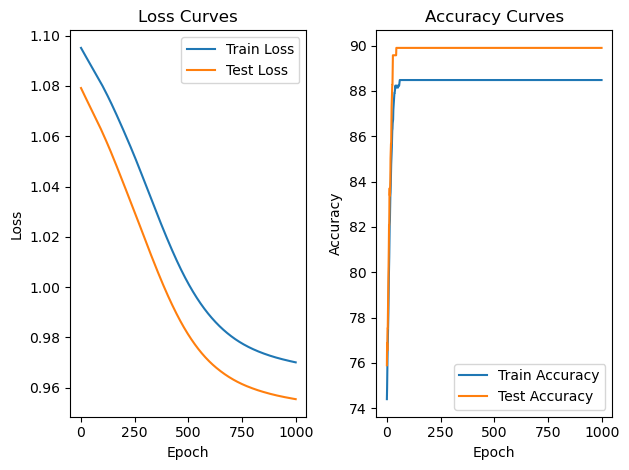

In [26]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# printing classification report
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_predictions = test_outputs.round().numpy()
    print(f'Classification Report:\n{classification_report(y_test.numpy(), test_predictions)}')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       276
         1.0       0.00      0.00      0.00        31

    accuracy                           0.90       307
   macro avg       0.45      0.50      0.47       307
weighted avg       0.81      0.90      0.85       307



/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### The model is predicting the majority class only.
#### Our Data is imbalance 
#### Adding more data will lead to better learning and accuracies
#### Techniques like Stratified k-fold cross-validation and Weighted Random sampling can be used to cater class imbalance